# Capturing Non-linear Effects with Linear Models

## 1. Overview
Linear regression assumes a straight-line relationship between the independent and dependent variables. However, a lot of the real-world data has variables that cannot be related linearly.

To capture these effects without abandoning the simplicity of linear regression, we can **apply a non-linear transformation** to the input variable before passing it on to train the model.

So basically, the model would now predict a linear relationship between the dependent variable, and the transformed input variable, thus capturing a non-linear relationship using the linear model.



## 2. Methodology
We transform the input $x$ using functions such as:

- **Logarithmic**: $ (z = \log(x))  $
  Useful when the response changes rapidly for small values of x but levels off for large x.

- **Square Root**: $( z = \sqrt{x} )$  
  Useful when the effect of x increases at a decreasing rate.

- **Polynomial**: $( z = x^2, x^3, \dots )$  
  Useful for capturing curvature in the data.

We then fit the model:
$$
y = w_0 + w_1 z
$$
where $z$ is the transformed version of $x$.

To represent in matrix form,

we transform the input variable $x$ into a new feature representation and produce the transformed input matrix $\phi$.  

### Examples of Transformations

- **Logarithmic**:  
  $
  \phi = \begin{bmatrix} 1 & \log(x) \end{bmatrix}
  $

- **Square Root**:  
  $
  \phi = \begin{bmatrix} 1 & \sqrt{x} \end{bmatrix}
  $

- **Polynomial**:  
  $
  \phi = \begin{bmatrix} 1 & x & x^2 & x^3 \end{bmatrix}
  $



### Linear Model with Transformed Input

The model is
$
y = \phi(x) \cdot w
$

where:
- $x$ = original input variable,  
- $\phi(x)$ = transformed feature vector
- w = weight vector.


This shows that we are still using a **linear regression model**, but on **non-linear transformations** of the input variable.


## 3. Multilingual Data Handling

When we have text data in multiple languages, we usually convert it into numerical features (via word embeddings, frequency counts, etc.) so that we can use machine learning models for analysis. Sometimes, the effect of these features on the target variable isn’t linear.

Suppose we compute word frequency from documents across multiple languages. The effect of frequency on the outcome (say, relevance or engagement) might saturate — beyond a point, more occurrences of the same word don’t add much.

To capture this, we can apply non-linear transformations before feeding them into linear regression:

Logarithm: $x' = log(1 + x)$ (useful for count-based features like word frequency).

By doing this, a linear regression model can still capture the curved relationship between text-derived features and the outcome.

## 4. FinTech Applications

In FinTech, consider the relationship between ad impressions (number of times a user sees an ad) and conversion rate (probability of signing up or purchasing).

This relationship is non-linear:

At first, more impressions increase conversions (positive effect).

After a threshold, additional impressions show diminishing returns (or even negative returns, e.g., user annoyance).

A raw linear regression on impressions would incorrectly assume that each additional impression increases conversion at a constant rate.

By applying a transformation:

Logarithm: $x' = log(1 + impressions)$ → captures the diminishing effect.

Square root: $x' = \sqrt(impressions)$ → smooths the effect of large values.

This way, even a simple linear regression can model the non-linear effect of ads on conversion without needing a full non-linear model.

## 5.Implementation

The following code parallely implements both linear and non-linear fits for data showing how the Customer Acquisition of a company changes with Marketing Spends.


For the data used below we transform $x$ to $x^\frac{1}{3}$.

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

url = 'https://raw.githubusercontent.com/Bhuvneshwar-git/Data_Files/main/marketing_spend_vs_acquisitions.csv'

df = pd.read_csv(url)

In [57]:
marketing_spend = df['MarketingSpend'].values.reshape(-1,1)
marketing_spend_scaled = (marketing_spend - marketing_spend.min()) / (marketing_spend.max() - marketing_spend.min())   # scaling down input values to keep in [0,1]
marketing_spend_scaled_transformed = np.pow(marketing_spend_scaled,1/3)   # transformed input

input = np.c_[np.ones((marketing_spend_scaled.shape[0], 1)), marketing_spend_scaled]  # augmenting input with a column of 1s
input_transformed = np.c_[np.ones((marketing_spend_scaled_transformed.shape[0], 1)), marketing_spend_scaled_transformed]

acquisitions = df['CustomerAcquisitions'].values.reshape(-1,1)
output = (acquisitions - acquisitions.min())/(acquisitions.max() - acquisitions.min())   # scaling down output to keep in [0,1]

In [58]:
def calculate_gradient(x, y, w):
  y_pred = x @ w
  error = y_pred - y
  gradient = (1/x.shape[0]) * (x.T @ error)
  return gradient

def mse(y, y_pred):
  return np.mean((y - y_pred)**2)

marketing_spend_train, marketing_spend_test, x_train, x_test, x_transformed_train, x_transformed_test, acquisitions_train, acquisitions_test, y_train, y_test = train_test_split(marketing_spend, input, input_transformed, acquisitions, output, test_size=0.2, random_state=42)

In [59]:
learning_rate = 0.01
n_iterations = 5000

# linear fit

w = np.random.randn(x_train.shape[1], 1)

for i in range(n_iterations):
  gradient = calculate_gradient(x_train, y_train, w)
  w = w - learning_rate * gradient

y_pred_linear = (x_train @ w)
y_pred_linear_scaled = y_pred_linear * (acquisitions.max() - acquisitions.min()) + acquisitions.min() # scaling up to get the actual predicted values for the plots
mse_linear_train = mse(y_train, y_pred_linear)


# non-linear fit

w1 = np.random.randn(x_transformed_train.shape[1], 1)

for i in range(n_iterations):
  gradient = calculate_gradient(x_transformed_train, y_train, w1)
  w1 = w1 - learning_rate * gradient

y_pred_nonlinear = (x_transformed_train @ w1)
y_pred_nonlinear_scaled = y_pred_nonlinear * (acquisitions.max() - acquisitions.min()) + acquisitions.min()
mse_nonlinear_train = mse(y_train, y_pred_nonlinear)

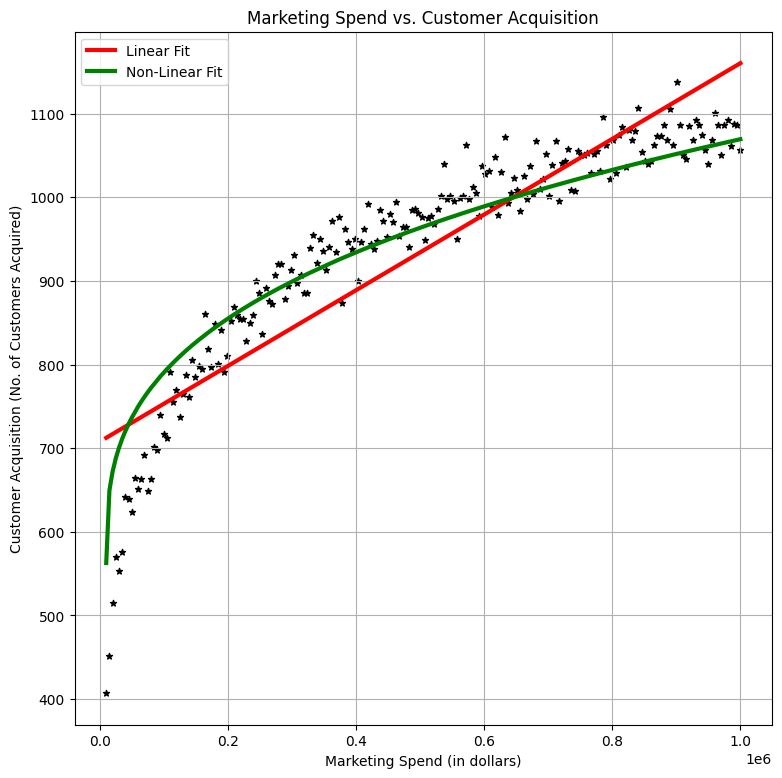

In [60]:
sorted_idx = np.argsort(marketing_spend_train[:, 0])

plt.figure(figsize=(9,9))
plt.scatter(marketing_spend, acquisitions, marker='*',s=20,color='black')
plt.plot(marketing_spend_train[sorted_idx], y_pred_linear_scaled[sorted_idx], color='red',lw=3, label='Linear Fit')
plt.plot(marketing_spend_train[sorted_idx], y_pred_nonlinear_scaled[sorted_idx], color='green',lw=3, label='Non-Linear Fit')
plt.xlabel('Marketing Spend (in dollars)')
plt.ylabel('Customer Acquisition (No. of Customers Acquired)')
plt.title('Marketing Spend vs. Customer Acquisition')
plt.grid(True)
plt.legend()
plt.show()

## 6. Evaluation

In [61]:
# mse of training data

print("MSE for Linear Fit on Train Data:", mse_linear_train)
print("MSE for Non-Linear Fit on Train Data:", mse_nonlinear_train)

# validation using unseen data

y_pred_linear_test = x_test @ w
mse_linear_test = mse(y_test, y_pred_linear_test)

y_pred_nonlinear_test = x_transformed_test @ w1
mse_nonlinear_test = mse(y_test, y_pred_nonlinear_test)

print("MSE for Linear Fit on Test Data:", mse_linear_test)
print("MSE for Non-Linear Fit on Test Data:", mse_nonlinear_test)

MSE for Linear Fit on Train Data: 0.007854982701106907
MSE for Non-Linear Fit on Train Data: 0.004164307017055025
MSE for Linear Fit on Test Data: 0.004968478539002169
MSE for Non-Linear Fit on Test Data: 0.0026575428084164594


As we can see, the model with transformed input performs better than the regular linear model, both in terms of learning the data (MSE on Train Data) as weel as generalizing to unseen examples (MSE of Test Data).

The Dataset used for the implementation was generated synthetically, as per a non-linear function and random noise was added.